# 2.4.6. Использование моделей Hugging Face для классификации (анализа тональности) текста.  

Видеоуроки:  
2.4.1. Векторное представление единиц текста.  
2.4.2. Обучение нейросетевой модели word2vec.  
2.4.3. Использование обученных моделей RusVectōrēs.  
2.4.4. Нейросетевая модель torch.embedding.  

Дополнительные материалы:  
2.4.5. Использование обученных моделей RusVectōrēs для классификации (анализа тональности) текста.  
**2.4.6. Использование моделей Hugging Face для классификации (анализа тональности) текста.**  

[Huggingface 🤗](https://huggingface.co) - библиотека и комьюнити, призванные решить большинство задач обработки текстов.  
Например такие задачи:  
* ответы на вопросы  
* определение схожести 2 текстов  
* суммаризация (краткое изложение) текста  
* классификация текстов  
* генерация текстов  
* автоматический перевод  
* распознавание речи и перевод текста в речь  

Полный список доступен по [ссылке](https://huggingface.co/tasks) 

На сайте проекта вы можете поэкспериментировать с готовыми моделями, а так же узнать детали реализации и скачать готовые примеры кода. Использование таких библиотек как [Huggingface 🤗](https://huggingface.co) значительно упрощает решение задач обработки текстов.  
Многие модели, доступные на сайте проекта, обучаются в течении длительного времени на кластерах из большого количества GPU. Обучить такую модель в небольшом проекте часто невозможно.   

В этом занятии мы скачаем готовую модель анализа тональности текста (sentiment analysis) и применим на нашем датасете.  

In [27]:
import logging
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn import metrics

plt.style.use('ggplot')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

if torch.cuda.is_available():
    model.cuda()

def get_sentiment(text, return_type='label'):
    """
    Получить тональность теста.

    Args:
        return_type (str) одно из значений 'label', 'score', 'proba'
    """

    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

text = 'Какая гадость эта ваша заливная рыба!'

print(get_sentiment(text, 'label'))  # negative

# оценка текста по шкале от -1 (очень негативные) to +1 (крайне позитивный)
print(get_sentiment(text, 'score'))  # -0.5894946306943893
# вероятности лейблов (negative, neutral, positive)
print(get_sentiment(text, 'proba'))  # [0.7870447  0.4947824  0.19755007]

negative
-0.5894947648048401
[0.78704476 0.4947824  0.19755   ]


In [11]:
! ls ./data/sentiment

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
sentiment-analysis-in-russian-lemmatized-topic.csv


In [23]:
df = pd.read_csv('./data/sentiment/sentiment-analysis-in-russian-lemmatized-topic.csv', sep=';', encoding='utf-8')
df.head()

,text,id,sentiment,Lemmed text,Topic label normalized
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative,досудебный расследование по факт покупка енпф ...,fin
1,Медики рассказали о состоянии пострадавшего му...,1957,negative,медик рассказать о состояние пострадавший мужч...,accid
2,"Прошел почти год, как железнодорожным оператор...",1969,negative,пройти почти год как железнодорожный оператор ...,kz
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative,по итог месяц год на территория республика вып...,fin
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative,астан ноябрь агентство рк по дело государствен...,kz


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8263 entries, 0 to 8262
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text                    8263 non-null   object
 1   id                      8263 non-null   int64 
 2   sentiment               8263 non-null   object
 3   Lemmed text             8263 non-null   object
 4   Topic label normalized  8263 non-null   object
dtypes: int64(1), object(4)
memory usage: 322.9+ KB


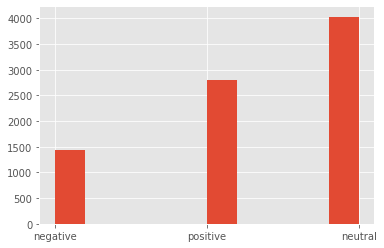

neutral     4034
positive    2795
negative    1434
Name: sentiment, dtype: int64

In [25]:
Y_COL = 'sentiment'
TEXT_COL = 'text'
df[Y_COL].hist()
plt.show()

df[Y_COL].value_counts()

Давайте проверим соответствие лейблы на выходе модели и лейблы в наших данных. Нам повезло - модель выдает именно то чтто нам нужно.  

In [26]:
model.config.label2id.keys(), df[Y_COL].unique()


(dict_keys(['negative', 'neutral', 'positive']),
 array(['negative', 'positive', 'neutral'], dtype=object))

Всего в нашем датасете больше 8 тысяч примеров. Чтобы ускорить обработку, протеститруем работу модели не на всех примерах, а только на части.

In [30]:
df_test = df.sample(1000)

accuracy: 0.876
f1: 0.876
confusion matrix:


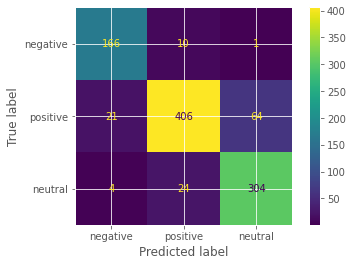

In [31]:
texts = df_test[TEXT_COL]
labels_true = df_test[Y_COL]
labels_predicted = [get_sentiment(t, 'label') for t in texts]


acc = metrics.accuracy_score(labels_true, labels_predicted)
f1 = metrics.f1_score(labels_true, labels_predicted, average='weighted')
print('accuracy: %0.3f' % acc)
print('f1: %0.3f' % f1)

print('confusion matrix:')
cm = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(labels_true, labels_predicted),
    display_labels=df[Y_COL].unique(),
)

cm.plot()
plt.show()

# Выводы 

- Библиотека [Huggingface 🤗](https://huggingface.co) позволяет минимальными усилиями решать большинство задач.  